In [1]:
# dataset load
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="8CzHJJr0mbSZN5Yndqlp")
project = rf.workspace("project-986i8").project("drone-uskpc")
dataset = project.version(1).download("tensorflow")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 25.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycler-0.12.1:
      Successfully uninstalled cycler-0.12.


Extracting Dataset Version Zip to Drone-1 in tensorflow:: 100%|██████████| 17714/17714 [00:07<00:00, 2239.29it/s]


In [2]:
import pandas as pd
import numpy as np
import cv2
import os
import re
# import pydicom
import warnings

from PIL import Image
import cv2

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

warnings.filterwarnings("ignore")


DIR_INPUT = '/kaggle/working/Drone-1'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_VALID = f'{DIR_INPUT}/valid'
DIR_TEST = f'{DIR_INPUT}/test'

In [3]:
train_df = pd.read_csv(f'{DIR_TRAIN}/_annotations.csv')#[:100]
print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class"].nunique()))
train_df['class_id']=1
train_df.sort_values(by='filename').head(10)

df Shape: (16872, 8)
No Of Classes: 1


,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
4666,0002_jpg.rf.3a790caf1b59c891e289907a084398c5.jpg,640,640,drone,344,236,426,290,1
12506,0002_jpg.rf.69e56a1e6be276fc287e9dcbdcfa6115.jpg,640,640,drone,350,269,425,292,1
13552,0002_jpg.rf.798f1d27a95f0f002d90c9492e72a142.jpg,640,640,drone,351,204,435,267,1
14343,0002_jpg.rf.84a8b847aa4ed282d3642992da46406b.jpg,640,640,drone,350,269,425,292,1
14467,0002_jpg.rf.86c39bbe6a8a5a3e42f948e035b9c9d0.jpg,640,640,drone,319,253,399,295,1
5585,0002_jpg.rf.90825f1af1d7397fba2fecf6039a4d0d.jpg,640,640,drone,380,242,462,278,1
7906,0005_jpg.rf.473308791aa6a3aa2b73cee5a2e59317.jpg,640,640,drone,182,100,286,177,1
9183,0005_jpg.rf.5b83ba0714843c5929a1c361b29bd50e.jpg,640,640,drone,287,84,374,116,1
6792,0005_jpg.rf.a2e07d9502095c12244587ef9ed93ab9.jpg,640,640,drone,367,88,464,155,1
15221,0005_jpg.rf.b5793489316a4a48acb5ac61458fb2a5.jpg,640,640,drone,306,67,399,106,1


In [4]:
valid_df = pd.read_csv(f'{DIR_VALID}/_annotations.csv')#[:10]
print("df Shape: "+str(valid_df.shape))
print("No Of Classes: "+str(valid_df["class"].nunique()))
valid_df['class_id']=1
valid_df.sort_values(by='filename').head(10)

df Shape: (1470, 8)
No Of Classes: 1


,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
256,0029_jpg.rf.2f03abd2787f80fb6d60bcbcbd785def.jpg,640,640,drone,288,87,372,111,1
1098,0035_jpg.rf.bfd4f4c0eee5602f6fa5ae16b8846bde.jpg,640,640,drone,290,93,369,108,1
419,0041_jpg.rf.4b20648c8273b207a5745fe2d5d9f52f.jpg,640,640,drone,298,92,373,116,1
1368,0056_jpg.rf.e915f958a82d46b707667dc5bcb0f98e.jpg,640,640,drone,319,92,406,110,1
11,0114_jpg.rf.025b24624438758236c3c31b79ea8418.jpg,640,640,drone,365,96,458,116,1
1117,0158_jpg.rf.c398b84fe65e2da8b79f41042f12b1ba.jpg,640,640,drone,311,97,375,120,1
6,0200_jpg.rf.01ae08a17440263514b38081f632e961.jpg,640,640,drone,373,92,458,120,1
328,0227_jpg.rf.3c972ec8cd7a3ea836b4726787a9808e.jpg,640,640,drone,372,94,460,121,1
487,0230_jpg.rf.5598cfd7bb60b7c0884c7b7cb68f47f0.jpg,640,640,drone,184,238,260,266,1
1058,0247_jpg.rf.b865ea618cbfdda1fadbd5966826b3cd.jpg,640,640,drone,304,98,388,116,1


In [5]:
# Thanks -  https://www.kaggle.com/pestipeti/
class VinBigDataset(Dataset): #Class to load Training Data

    def __init__(self, dataframe, image_dir, transforms=None,stat = 'Train'):
        super().__init__()

        self.image_ids = dataframe["filename"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.stat = stat

    def __getitem__(self, index):
        if self.stat == 'Train':

            image_id = self.image_ids[index]
            records = self.df[(self.df['filename'] == image_id)]
            records = records.reset_index(drop=True)

            # dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            # image = dicom.pixel_array

            # if "PhotometricInterpretation" in dicom:
            #     if dicom.PhotometricInterpretation == "MONOCHROME1":
            #         image = np.amax(image) - image

            # intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            # slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            # if slope != 1:
            #     image = slope * image.astype(np.float64)
            #     image = image.astype(np.int16)


            # image += np.int16(intercept)

            # image = np.stack([image, image, image])
            # image = image.astype('float32')
            # image = image - image.min()
            # image = image / image.max()
            # image = image * 255.0
            # image = image.transpose(1,2,0)
            image = cv2.imread(f"{self.image_dir}/{image_id}")
            image = image / 255.0

            # if records.loc[0, "class_id"] == 0:
            #     records = records.loc[[0], :]

            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            # target['image_id'] = torch.tensor([index])
            # target['area'] = area
            # target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes'])

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
                # target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)

            return image, target, image_id

        else:

            image_id = self.image_ids[index]
            records = self.df[(self.df['filename'] == image_id)]
            records = records.reset_index(drop=True)

            # dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            # image = dicom.pixel_array

            # intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            # slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            # if slope != 1:
            #     image = slope * image.astype(np.float64)
            #     image = image.astype(np.int16)

            # image += np.int16(intercept)

            # image = np.stack([image, image, image])
            # image = image.astype('float32')
            # image = image - image.min()
            # image = image / image.max()
            # image = image * 255.0
            # image = image.transpose(1,2,0)
            image = cv2.imread(f"{self.image_dir}/{image_id}")
            image = image / 255.0

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
num_classes = 2 # 

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, ToTensorV2(p=1.0))#, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, ToTensorV2(p=1.0))#, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

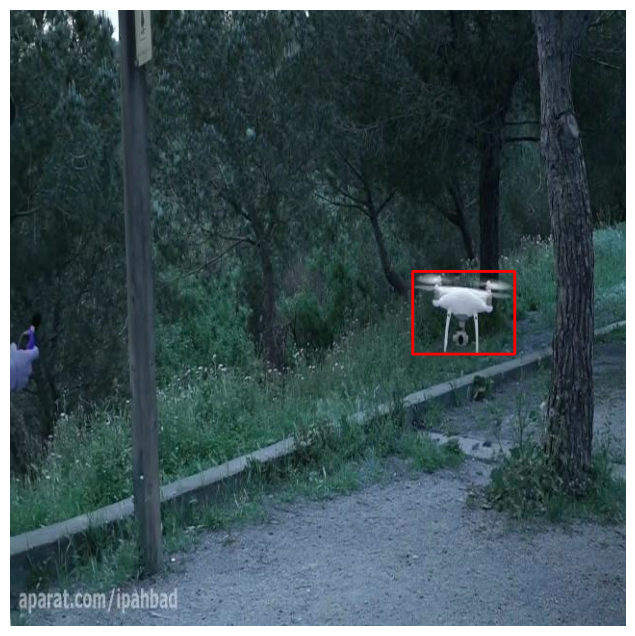

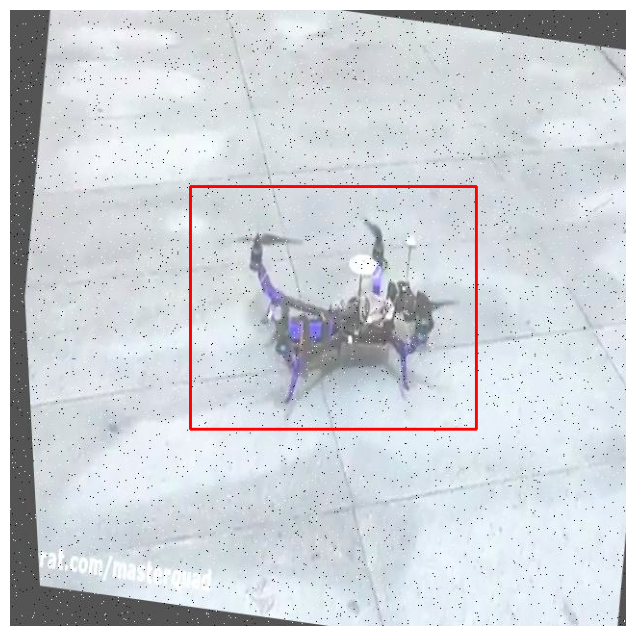

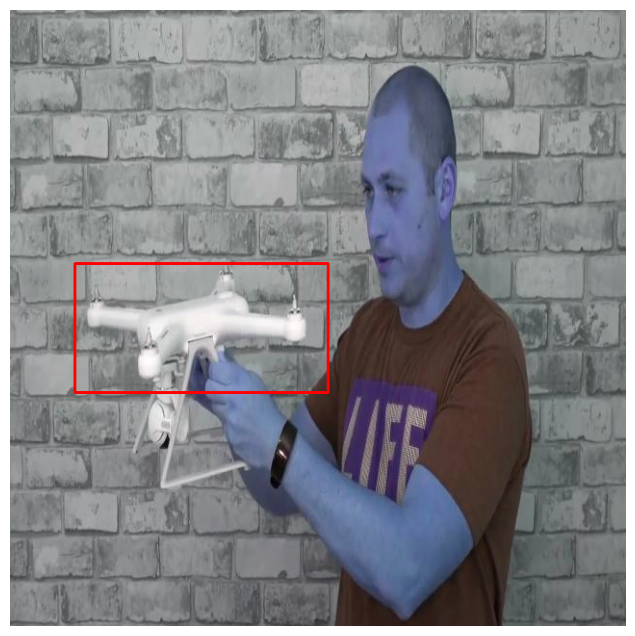

In [7]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3],3):
  boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
  img = images[number].permute(1,2,0).cpu().numpy()
  labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))

  for i in range(len(boxes)):
      img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
      #print(le.inverse_transform([labels[i]-1])[0])
      #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
      # img = cv2.putText(img, labels[i], (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

  ax.set_axis_off()
  ax.imshow(img)

In [8]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [10]:
# Model class must be defined somewhere
# import torch
# model = TheModelClass(*args, **kwargs)
# model.load_state_dict(torch.load('/kaggle/input/model1/mymodel (3).pth'))
# model.eval()
# print(model)
# model = model['model_state_dict']
# print(model)
# model = torch.load('/kaggle/input/model-2/mymodel_2.pth',map_location=torch.device('cpu'))
# /kaggle/input/model-2/mymodel_2.pth
# model.eval()
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# model.eval()
# # - or -
# model.train()

In [11]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  10 #Low epoch to save GPU time

In [ ]:
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()
import tqdm
for epoch in range(num_epochs):
    loss_hist.reset()

    for images, targets, image_ids in tqdm.tqdm(train_data_loader):

        images = list(image.float().to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

In [ ]:
# torch.save(model.state_dict(), '/kaggle/working/model')
# from pytorch_lightning.callbacks import ModelCheckpoint
# model.save_checkpoint("mymodel.ckpt")
# new_model = MyModel.load_from_checkpoint(checkpoint_path="example.ckpt")
torch.save(model, '/kaggle/working/mymodel_3.pth')


In [ ]:
# torch.save({'epoch': 10,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': lossHistoryepoch}, '/kaggle/working/mymodel.pth')

In [ ]:
# Plot training loss
import matplotlib.pyplot as plt
# x = [i for i in range(num_epochs)]
y = lossHistoryepoch
# Plot scatter plot of training loss
x = np.arange(1, num_epochs+1)
colors = y  # Use loss values as colors

plt.plot(x, y, marker='o', linestyle='-')#, color=plt.cm.viridis(colors))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
# plt.colorbar(label='Loss')
plt.grid(True)
plt.show()
# plt.savefig('plot.jpg')

In [ ]:
# import plotly.graph_objects as go

# x = [i for i in range(num_epochs)]
# y = lossHistoryepoch
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=x,y=y,
#                     mode='lines',
#                     name='lines'))

# fig.update_layout(title='Loss vs Epochs',
#                    xaxis_title='Epochs',
#                    yaxis_title='Loss')
# fig.show()

In [12]:
DIR_TEST = f'{DIR_INPUT}/test'
test_df = pd.read_csv(f'{DIR_TEST}/_annotations.csv')#[:100]
print("df Shape: "+str(test_df.shape))
print("No Of Classes: "+str(test_df["class"].nunique()))
test_df['class_id']=1
test_df.sort_values(by='filename').head(10)

df Shape: (719, 8)
No Of Classes: 1


,filename,width,height,class,xmin,ymin,xmax,ymax,class_id
115,0003_jpg.rf.221764dff4ad0a1b94c09b3c606d497c.jpg,640,640,drone,281,80,375,109,1
441,0014_jpg.rf.9946695ac3a26f54fed495f1b49409d3.jpg,640,640,drone,364,264,430,285,1
470,0154_jpg.rf.a431efc2fd080bb45197b6fecae13541.jpg,640,640,drone,385,98,459,119,1
466,0222_jpg.rf.a3f45f5b903641a39afb14ae5c83d12a.jpg,640,640,drone,372,94,453,118,1
62,0234_jpg.rf.1120ed29ddaeae58f6421bb81811fe44.jpg,640,640,drone,340,95,425,120,1
538,0254_jpg.rf.b993fd71b1c1fc21641c9e5d89a81334.jpg,640,640,drone,217,116,286,140,1
402,0256_jpg.rf.8d201cc28bbbe087b4e4fe15ab33c868.jpg,640,640,drone,304,96,380,123,1
551,0266_jpg.rf.c0b7e0c4839227e0bf6bd3c9f9ea20b4.jpg,640,640,drone,195,151,265,185,1
452,0269_jpg.rf.9d807920181b82276b7395780b7fbf3a.jpg,640,640,drone,288,136,360,157,1
334,0333_jpg.rf.773d1038723b70466236bfa91e90e6c5.jpg,640,640,drone,308,91,408,118,1


In [13]:
labels =  targets[1]['labels'].cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")

In [14]:
test_dataset = VinBigDataset(test_df, DIR_TEST, ToTensorV2(p=1.0))#,"Test")

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1,
    drop_last=False,
    collate_fn=collate_fn
)

In [15]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

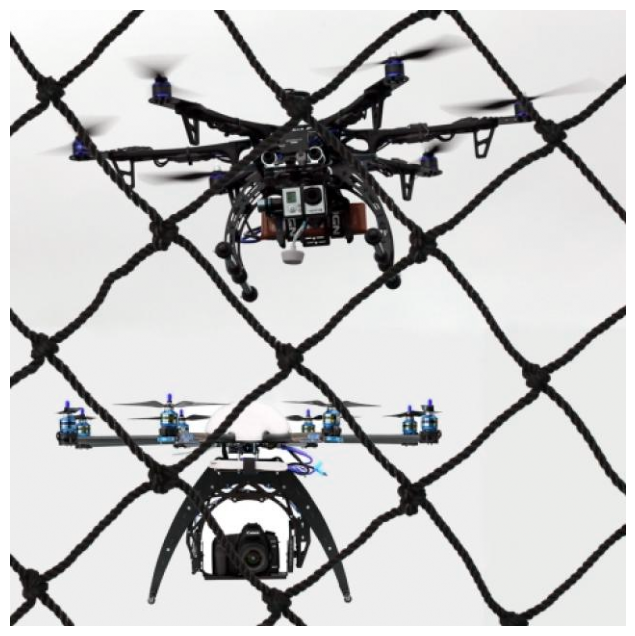

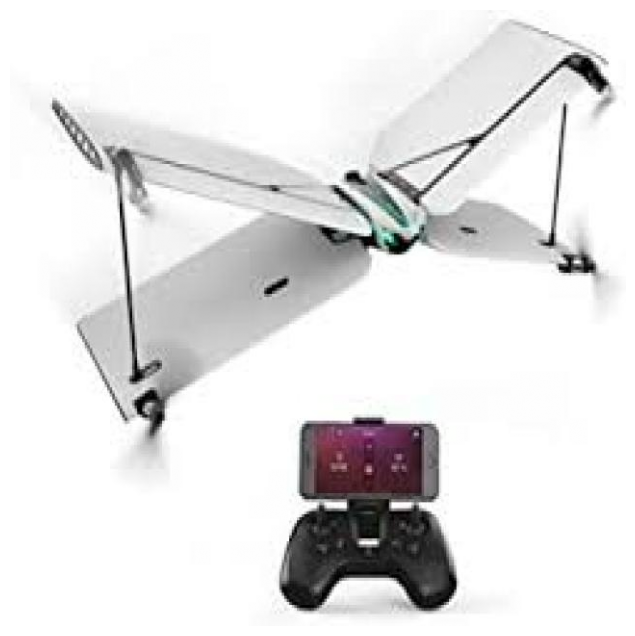

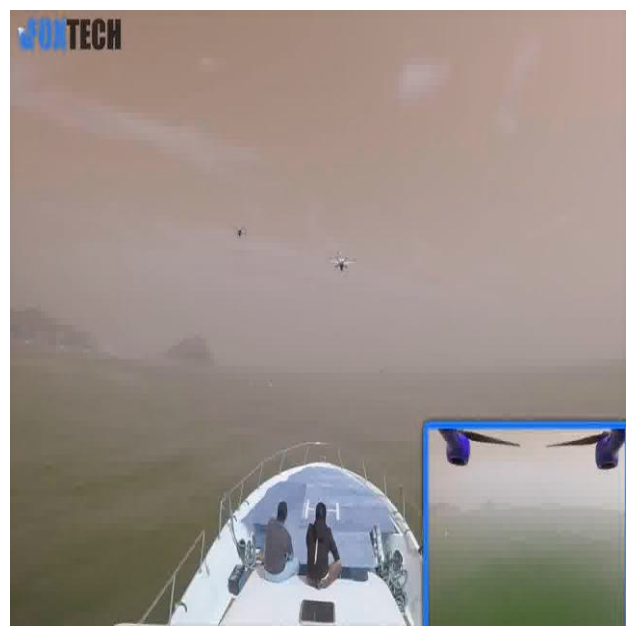

In [16]:
# Test dataset sample
images,target, image_ids = next(iter(test_data_loader))
images = list(image.to(device) for image in images)

for number in random.sample([1,2,3],3):
  img = images[number].permute(1,2,0).cpu().numpy()
  #labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  ax.set_axis_off()
  ax.imshow(img)

In [33]:
### Test images
images,target, image_ids = next(iter(test_data_loader))
images = list(img.float().to(device) for img in images)

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]


boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().detach().numpy()
labels= outputs[0]['labels'].cpu().detach().numpy().astype(np.int32)
score = outputs[0]['scores']
# print(score)

fig, ax = plt.subplots(1,1,figsize=(16, 8))

img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
for i in range(len(boxes)):
  img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
  #print(le.inverse_transform([labels[i]-1])[0])
#   print(label_to_name(labels[i]), (boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize))
  # img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,3, (255,0,0), 3, cv2.LINE_AA)
t_boxes = target[0]['boxes'].cpu().detach().numpy().astype(np.int32)
for i in range(len(t_boxes)):
  img = cv2.rectangle(img,(t_boxes[i][0]+paddingSize,t_boxes[i][1]+paddingSize),(t_boxes[i][2]+paddingSize,t_boxes[i][3]+paddingSize),(0,0,255),2)
  
ax.set_axis_off()
ax.imshow(img)

OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 165.06 MiB is free. Process 4397 has 14.58 GiB memory in use. Of the allocated memory 13.99 GiB is allocated by PyTorch, and 474.23 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [27]:
# torch.cuda.empty_cache()

In [28]:
import time
import tqdm

ovthresh=0.5
use_07_metric=True
tp = 0
fp = 0
npos = 0
def voc_ap(rec, prec, use_07_metric=True):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:True).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap



Total_score = 0
Total_overlaps = 0
start = time.time()
for images, targets, image_ids in tqdm.tqdm(test_data_loader):
    images = list(image.float().to(device) for image in images)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(images)

    for tar,out in zip(targets,outputs):
#         print(tar['boxes'].size(),out['boxes'].size())
        score = out['scores'].sum()
        Total_score = Total_score + score
        
        bb = tar['boxes'].cpu().detach().numpy()
        BBGT = out['boxes'].cpu().detach().numpy()
        ixmin = np.maximum(BBGT[:, 0], bb[0,0])
        iymin = np.maximum(BBGT[:, 1], bb[0,1])
        ixmax = np.minimum(BBGT[:, 2], bb[0,2])
        iymax = np.minimum(BBGT[:, 3], bb[0,3])
        iw = np.maximum(ixmax - ixmin, 0.)
        ih = np.maximum(iymax - iymin, 0.)
        inters = iw * ih
        uni = ((bb[0,2] - bb[0,0]) * (bb[0,3] - bb[0,1]) +
                (BBGT[:, 2] - BBGT[:, 0]) *
                (BBGT[:, 3] - BBGT[:, 1]) - inters)
        overlaps = inters / uni
#         print(overlaps)
        Total_overlaps = Total_overlaps + overlaps.sum()
        
        if overlaps.size==0:
#             overlaps=[0]
            continue
#         else:
#             continue
        ovmax = np.max(overlaps)
        jmax = np.argmax(overlaps)
        if ovmax > ovthresh:
            tp+=1
        else:
            fp+=1
        npos+=bb.shape[0]
        

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Test the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

rec = tp / float(npos)
prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
ap = voc_ap(rec, prec, use_07_metric)
IOU = Total_overlaps/npos
confidence = Total_score/npos

  5%|▍         | 4/85 [00:03<01:05,  1.24it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 314.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 11.06 MiB is free. Process 2169 has 14.73 GiB memory in use. Of the allocated memory 13.84 GiB is allocated by PyTorch, and 774.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [35]:
print('mean average precision:',ap)
print('confidence :',confidence)
print("IoU:", IOU)

NameError: name 'ap' is not defined

In [20]:
torch.cuda.empty_cache()

5


  0%|          | 0/5 [00:00<?, ?it/s]

3
Number : 1
Time taken to per image the model :00:00:03.78
label: [1 1 1 1 1 1 1 1 1 1 1] -  score: [0.9994288  0.9990426  0.9982551  0.9789113  0.9588799  0.9087342
 0.85839504 0.8440416  0.8124482  0.15077782 0.10995068]


 20%|██        | 1/5 [00:04<00:16,  4.25s/it]

3
Number : 2
Time taken to per image the model :00:00:04.64
label: [1 1] -  score: [0.9995523 0.0643374]


 40%|████      | 2/5 [00:09<00:14,  4.78s/it]

3
Number : 3
Time taken to per image the model :00:00:04.67
label: [1 1] -  score: [0.9996101 0.6117002]


 60%|██████    | 3/5 [00:14<00:10,  5.08s/it]

3
Number : 4
Time taken to per image the model :00:00:04.13
label: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] -  score: [0.9999087  0.99911255 0.99904984 0.9982843  0.9979352  0.99712783
 0.9901938  0.98439723 0.98041725 0.9713482  0.96080637 0.95967746
 0.95292234 0.9488212  0.9361396  0.9193362  0.9179554  0.9004724
 0.88760287 0.8488296  0.77811724 0.67635405 0.6591154  0.6572007
 0.64154685 0.48771927 0.43727782 0.12769237 0.12044597 0.11569362
 0.05758054]


 80%|████████  | 4/5 [00:19<00:04,  4.85s/it]

3
Number : 5
Time taken to per image the model :00:00:05.21
label: [1 1 1 1 1 1 1 1] -  score: [0.9996499  0.99828184 0.99795663 0.9960407  0.95235795 0.31319678
 0.1057118  0.08140853]


100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


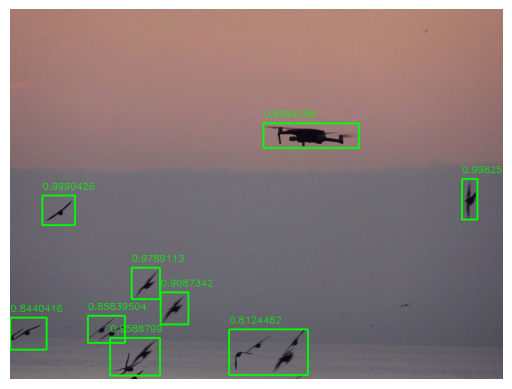

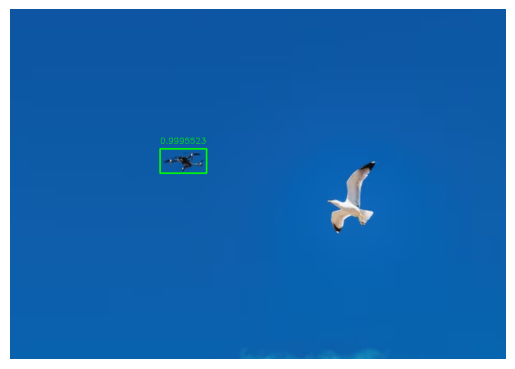

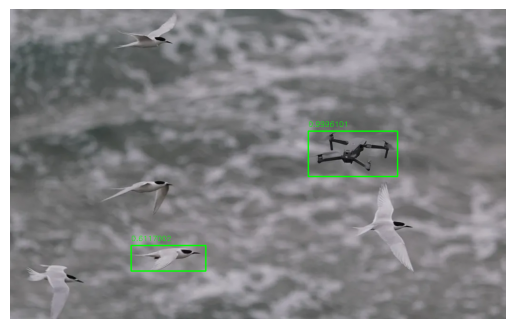

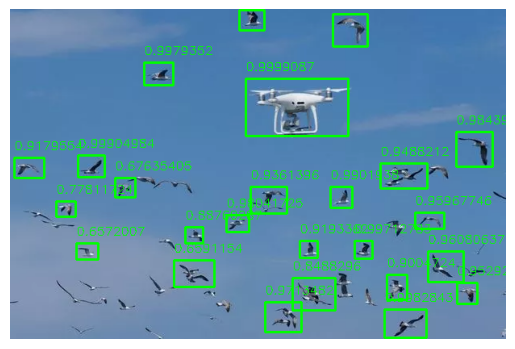

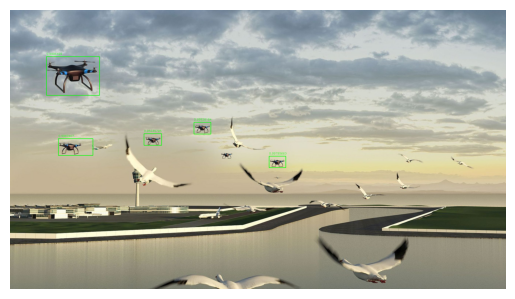

In [41]:
### predict images
import cv2
import os
import tqdm
import time

folder_path = '/kaggle/input/images-3'

# Get list of files in the folder
file_list = os.listdir(folder_path)

# Read each image in the folder
list_image = []
for file_name in file_list:
#     if file_name.endswith('.jpg') or file_name.endswith('.png'):
        image_path = os.path.join(folder_path, file_name)
#         print(image_path)
        image = cv2.imread(image_path)
        if image is not None:
            list_image.append(image)
# print(len(list_image))
counter = 1
print(len(list_image))
for images in tqdm.tqdm(list_image):
    image = torch.tensor(images).to(device)
    image = image/255.0
    image = image.unsqueeze(0)
    image = image.permute(0,3,1,2)
#     image = image.squeeze(0)
    
#     images.to(device)
    start = time.time()
    outputs = model(image)
    print(len(outputs[0]))
    outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
    end = time.time()
    
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print('Number :',counter )
    print("Time taken to per image the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    boxes = outputs[0]['boxes'].cpu().detach().numpy().astype(np.int32)
    img = image.permute(0,2,3,1).cpu().detach().numpy()
    img = img.squeeze(0)
    labels= outputs[0]['labels'].cpu().detach().numpy().astype(np.int32)
    score = outputs[0]['scores'].cpu().detach().numpy()
    print('label:',labels ,'-  score:', score)
    

    fig, ax = plt.subplots(1, 1)#, figsize=(8, 5))
    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2BGR)
    for i in range(len(boxes)):
      if score[i]>0.60: 
        img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(0,255,0),2)
        img = cv2.putText(img,str(score[i]),(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize-10),font,0.5,(0,255,0),1)

    ax.set_axis_off()
    ax.imshow(img)
    fig.savefig(f'{counter}.jpeg',dpi = 600)
    
    counter = counter + 1